In [2]:
from IPython.display import HTML

HTML('''
<script>code_show=true; 

function code_toggle() {
    if (code_show){
    $('div.input').hide();
    } else {
    $('div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to show or hide your raw code."></form>
''')

# The MNIST Problem

The MNIST database (Modified National Institute of Standards and Technology database[1]) is a large database of handwritten digits that is commonly used for training and testing advanced machine learning algorithms. General references are:

**MNIST database**. Wikipedia. https://en.wikipedia.org/wiki/MNIST_database.

**THE MNIST DATABASE of handwritten digits**. Yann LeCun, Courant Institute, NYU Corinna Cortes, Google Labs, New York Christopher J.C. Burges, Microsoft Research, Redmond. http://yann.lecun.com/exdb/mnist/

**Classification datasets results**. Rodrigo Benenson. https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html

The MNIST database contains 60,000 training images and 10,000 testing images. In our dataset the images will be 32 x 32 greyscale digit rasters.
In order to manage our computations in reasonable time, we are going to work only with the test subset, which we will further randomly split in a 20% train and validation subset and an 80% test subset.

### Student contributions

* Student `Mohammed Hussein` has worked over the model implementations, KNN and MLP: hypertuning and design.
* Student `Sebastian Cajas` has worked over the Data exploration, docummentation/testing of the models.

In [181]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [182]:
import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

from sklearn.pipeline import Pipeline

## Loading Data

Notice that the shape of each pattern is given by a $32 \times 32 \times 1$ tensor. Thus, you may have to reshape it to either a matrix or a vector depending on the task you want to perform.

In [728]:
f_bnch = "mnist_32_32.bnch.joblib"
mnist = joblib.load(f_bnch)
print(mnist.keys())

print("1. DESCR: {0}".format(mnist['DESCR']))
print("2. Target test: {0}".format(mnist['target_test'].shape))
print("3. data_test_shape: {0}".format(mnist['data_test'].shape))


dict_keys(['DESCR', 'target', 'target_test', 'data', 'data_test'])
1. DESCR: MNIST data set from Lecun site: http://yann.lecun.com/exdb/mnist/
2. Target test: (10000,)
3. data_test_shape: (10000, 1024)


In [729]:
X_test  = pd.DataFrame(data=mnist['data_test'])
Y_test  = pd.DataFrame(data=mnist['target_test'])

print(X_test.shape)
print(Y_test.shape)

(10000, 1024)
(10000, 1)


In [730]:
nan = X_test.isnull().sum()
print(nan[nan != 0])


Series([], dtype: int64)


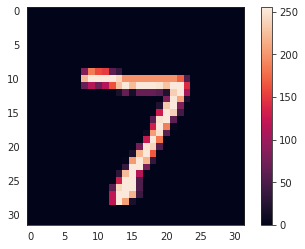

In [732]:
plt.figure()
plt.imshow(X_test.iloc[0].values.reshape(32,32))
plt.colorbar()
plt.grid(False)
plt.show()

## Data Exploration, Visualization and Correlations

Descriptive statistics, boxplots and histograms.

### Some examples

Plot 10 randomly chosen digit images as 5 x 2 subplots.

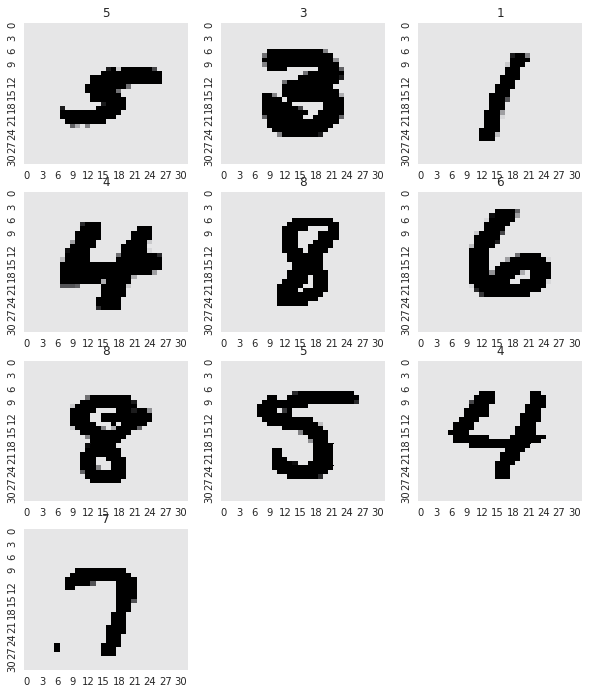

In [735]:
df = X_test.copy()
df['target'] = pd.DataFrame(data=mnist['target_test'])
cMap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0)
plt.figure(figsize=(10, 15))
for i in range(10):
    plt.subplot(5, 3, i+1) 
    #select images randomly
    idx = np.random.randint(low=0, high=len(df['target']))
    plt.title(int(df['target'][idx]))
    h_map = sns.heatmap(X_test.iloc[idx].values.reshape(32, 32),
                    vmin=0., vmax=16., 
                    cmap=cMap, 
                    cbar=False,
                    #annot=True, 
                   )
plt.show()

### Descriptive analysis

Build a DataFrame to make easier the exploratory analysis.

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 1025 entries, 0 to target
dtypes: uint8(1025)
memory usage: 9.8 MB


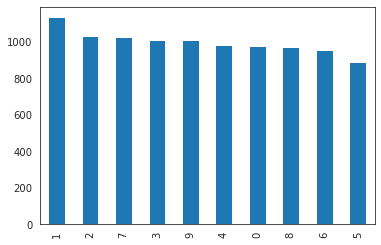

In [35]:
_ = df['target'].value_counts().plot(kind='bar')
plt.show()

In [36]:
pixel_range = X_test.loc[:,494:502]
X_test.loc[:,494:502].describe(include='all')

494           495           496           497           498  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      84.414300     96.372400    113.705900    127.309600    132.804900   
std      106.120561    109.081183    114.304354    112.306614    109.878282   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        2.000000     25.000000     72.000000    132.000000    149.000000   
75%      208.000000    233.000000    252.000000    253.000000    252.000000   
max      255.000000    255.000000    255.000000    255.000000    255.000000   

                499           500           501          502  
count  10000.000000  10000.000000  10000.000000  10000.00000  
mean     128.993700    109.990500     80.920600     55.46380  
std      112.465829    111.900516    104.666924     93.53993  
min        0.000000      0.000000      0.000000      0.00000  
25%        0.000000      0.000000      0.000000      0.00000  
50%      140.000000     67.000000      0.000000      0.00000  
75%      252.000000    252.000000    193.000000     79.00000  
max      255.000000    255.000000    255.000000    255.00000

Describe the basic statistics of the pixels on the positions in the range `[494 : 502]` of the reshaped patterns.

### Boxplots

Compute and display the boxplots of pixels in the range `[494 : 502]`.

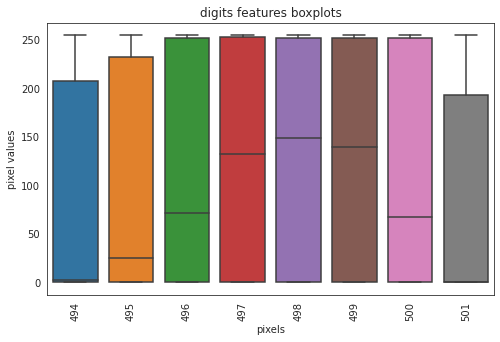

In [37]:
#code the boxplots here
########## feature boxplots 
plt.figure( figsize=(8, 5))
plt.title("digits features boxplots")
sns.set_style("white")
bx_plot = sns.boxplot(data=df[df.columns[494:502]]) #there are 65 diff cols
plt.xticks(rotation=90)
plt.xlabel("pixels")
plt.ylabel("pixel values")
plt.show()

In [38]:
X_test.loc[:,494:500].head(10)

494  495  496  497  498  499  500
0    0    0    0    0    0  129  254
1  253  233   35    0    0    0    0
2    0   57  237  205    8    0    0
3    0    0    0    0    0    0   31
4    0    0    0    0    0  134  252
5    0  111  254  254  132    0    0
6  253  253  253  254  253  253  219
7    0    0  234  253  254  135    0
8    0    0    0    0    0    0    0
9  178  178  169  210  251  231  254

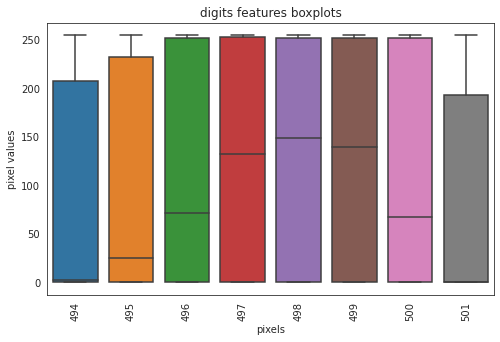

In [39]:
#code the boxplots here
########## feature boxplots 
plt.figure( figsize=(8, 5))
plt.title("digits features boxplots")
sns.set_style("white")
bx_plot = sns.boxplot(data=df[df.columns[494:502]]) #there are 65 diff cols
plt.xticks(rotation=90)
plt.xlabel("pixels")
plt.ylabel("pixel values")
plt.show()


### Histograms and scatterplots

Plot pairplots and histograms over the previous pixel range using `sns.pairplot`.  
To do so select first two target digits (e.g., 2 and 7) and apply `pairplot` only on patterns from those two targets.

In [40]:
# Select range: From the already extracted range, add target and filter by 2 and 7
pixel_range = pd.merge(pixel_range, Y_test, left_index=True, right_index=True)
pixel_range2 = pixel_range[(pixel_range[0]==2) | (pixel_range[0]==7)]

In [41]:

pixel_range2

494  495  496  497  498  499  500  501  502  0  
0       0    0    0    0    0  129  254  238   44    7
1     253  233   35    0    0    0    0    0    0    2
17      0    0    0    0    0    0  115  254  254    7
26      0    0    0    0    0  162  253  151    0    7
34      0    0    0   13  241  252  252  126   24    7
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
9979    0    0    0    0    0   52  232  252  239    7
9980    1   85  198  253  253  253  197  253  253    2
9985    0    0   13  176  253  253  224    0    0    2
9990    0    0   44  240  253  253  227    0    0    7
9995    0    0    0  191  255  255  255    0    0    2

[2060 rows x 10 columns]

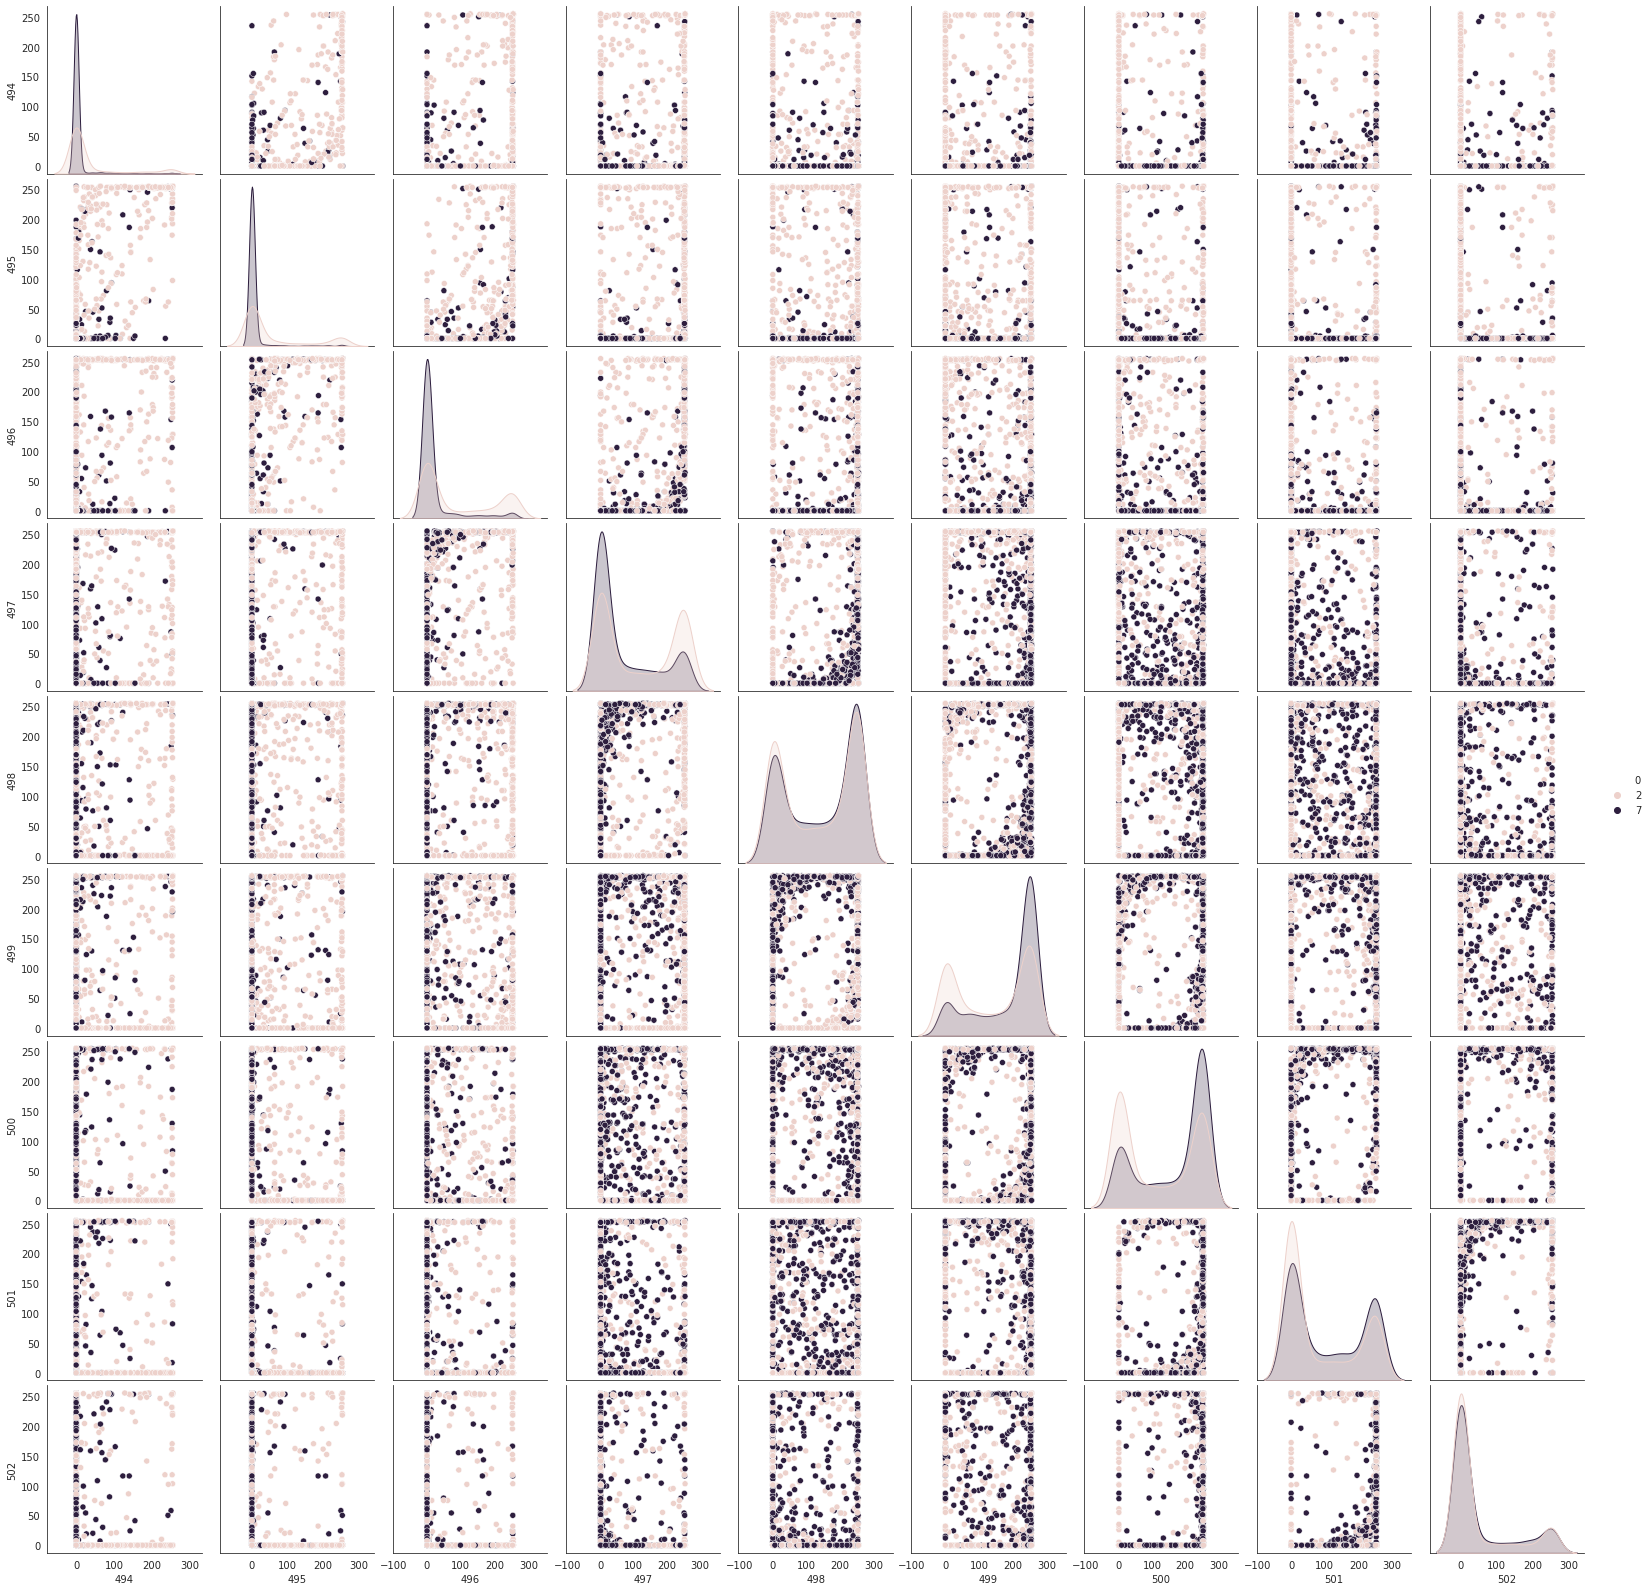

In [42]:

#select two target digits and apply sns.pairplot on the indicated pixel range
pair_plot = sns.pairplot(pixel_range2, hue= 0, diag_kind="kde", diag_kws=dict(shade=True))
plt.show()

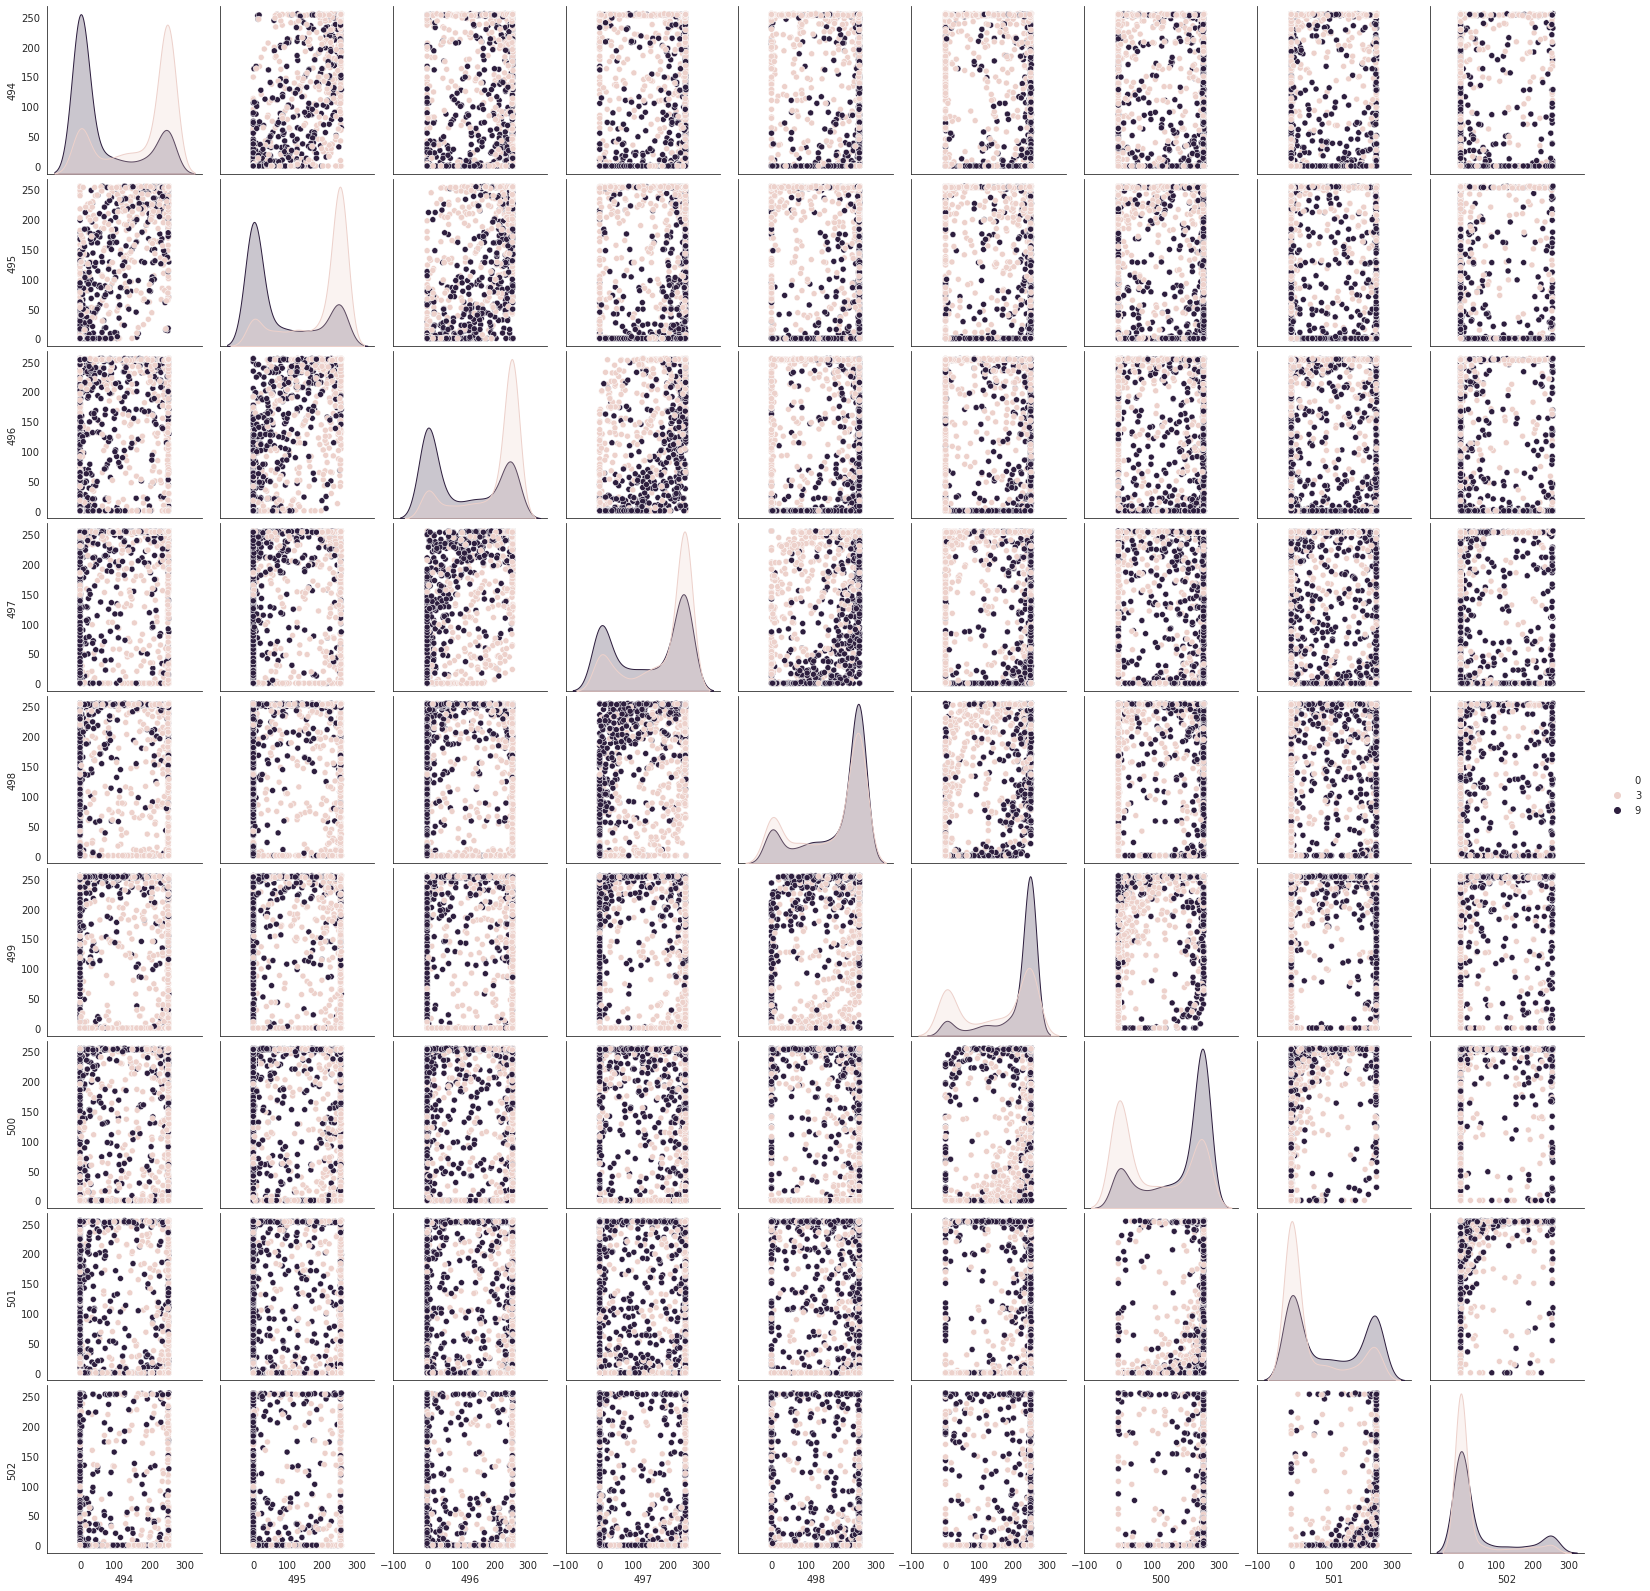

In [43]:
pixel_range2 = pixel_range[(pixel_range[0]==3) | (pixel_range[0]==9)]
pair_plot = sns.pairplot(pixel_range2, hue= 0, diag_kind="kde", diag_kws=dict(shade=True))
plt.show()

### Correlations

Use the previous pixel range but drop the `target` column.

Use directly a heatmap to display the correlations.

In [44]:
#display the correlations of the pixel range as a heatmap
pixel_range2.drop(columns=0,axis = 1, inplace  = True)

pixel_range2

494  495  496  497  498  499  500  501  502
7       0    0  234  253  254  135    0    0    0
9     178  178  169  210  251  231  254  254  254
12      0    0    0    5  136  252  252   64    0
16      0    0    0    0    6  219  253  241   31
18    253  253  253  253  253  253  253  244   89
...   ...  ...  ...  ...  ...  ...  ...  ...  ...
9973    0    0    0   17  103  236  253  224   39
9975    0    0   17  185  254  254   62    0    0
9986   45  200  253  253  253  133    0    0    0
9992    0    0    0  112  229  253  253  254  253
9996    0   77  185  230  254  254  254  239   45

[2019 rows x 9 columns]

In [45]:
pixel_range2.corr().round(decimals=3)

494    495    496    497    498    499    500    501    502
494  1.000  0.878  0.652  0.381  0.073 -0.174 -0.250 -0.243 -0.167
495  0.878  1.000  0.853  0.544  0.151 -0.166 -0.283 -0.281 -0.202
496  0.652  0.853  1.000  0.803  0.362 -0.050 -0.261 -0.292 -0.238
497  0.381  0.544  0.803  1.000  0.706  0.218 -0.134 -0.256 -0.250
498  0.073  0.151  0.362  0.706  1.000  0.679  0.193 -0.103 -0.219
499 -0.174 -0.166 -0.050  0.218  0.679  1.000  0.664  0.233 -0.033
500 -0.250 -0.283 -0.261 -0.134  0.193  0.664  1.000  0.687  0.300
501 -0.243 -0.281 -0.292 -0.256 -0.103  0.233  0.687  1.000  0.690
502 -0.167 -0.202 -0.238 -0.250 -0.219 -0.033  0.300  0.690  1.000

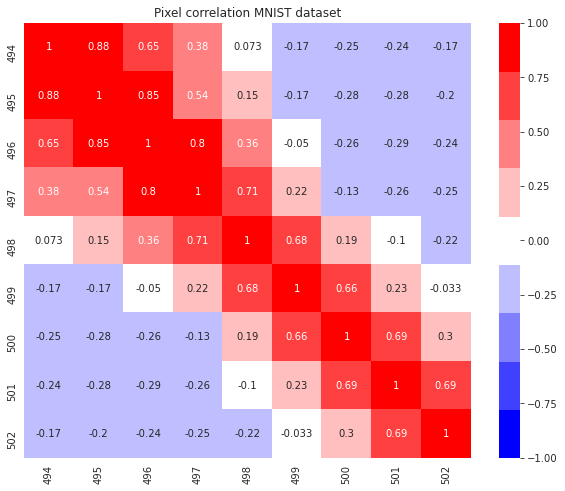

In [46]:
n_colors = 9
cMap = plt.cm.get_cmap("bwr", lut = n_colors)
plt.figure( figsize=(10, 8))
plt.title("Pixel correlation MNIST dataset")
h_map = sns.heatmap(pixel_range2.corr().values, vmin = -1., vmax = 1., cmap = cMap, annot = True, xticklabels = list(pixel_range2), yticklabels = list(pixel_range2))
plt.xticks(rotation=90)
plt.show()

### Data Analysis Conclusions

Write down here a summary of your conclusions after the basic data analysis

### Remarks: 
The columns 494-500 have 0-255 set-values on grayscale, since the images were set on 1 channel, this means that there is a thresholding change from black to white or grayscale. The mean starts in 86, increases up to 129 and decreases again until 55. Meaning that in most of the images there is a high information content fo white color in this area. Considering the standard deviation, the 50% and 75% percentil, this areas are mostly white on all images.

# Classiffiers

We are going to build a $k$-NN and an MLP classifier **over the test dataset**.  
But before working with any classifier, we split first the test dataset into a train-validation and a test subset.  
Use for this the class `StratifiedShuffleSplit` from scikit-learn. Set the `test_size` parameter to either `0.5` or `0.75`.

### Splitting the test dataset

In [51]:
# import the necessary packages
from __future__ import print_function
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn import datasets
from skimage import exposure
import numpy as np
import imutils
import cv2
import sklearn
from sklearn.model_selection import StratifiedShuffleSplit 

In [535]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=123)
sss.get_n_splits(X_test, Y_test)

5

In [536]:
for train_index, test_index in sss.split(X_test, Y_test):
    trainData, valData = X_test.loc[train_index], X_test.loc[test_index]
    trainLabels, valLabels = Y_test.loc[train_index], Y_test.loc[test_index]

In [538]:
print("Train Data shape:")
print(trainData.shape, trainLabels.shape)
print("\nTest Data shape:")
print(valData.shape, valLabels.shape)


Train Data shape:
(5000, 1024) (5000, 1)

Test Data shape:
(5000, 1024) (5000, 1)


In [539]:
trainLabels = trainLabels.iloc[:].values.reshape(5000,)
valLabels   = valLabels.iloc[:].values.reshape(5000,)

## k-NN Classification

### Grid Search of Optimal Number of neighbors

### Search Results 

We first examine the test scores of the 5 best hyperparameters.

In [56]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

#define the model and parameters
knn = KNeighborsClassifier()

k_p = [1,3,5,7,9]
parameters = {'n_neighbors':k_p}

#Fit the model
model = GridSearchCV(knn, param_grid=parameters, scoring='accuracy', verbose=2)

In [57]:
model.fit(trainData,trainLabels)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... n_neighbors=1, total=   8.3s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s remaining:    0.0s


[CV] .................................... n_neighbors=1, total=   8.7s
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total=   8.8s
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total=   9.0s
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total=   8.8s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   9.0s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   9.0s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   8.8s
[CV] n_neighbors=3 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  3.8min finished


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9]}, scoring='accuracy',
             verbose=2)

We analyze the CV results to check whether the CV ranges used are correct.

In [58]:
# Plot the test scores that correspond to each number of neighbors
KNN_search = pd.DataFrame.from_dict(model.cv_results_)
mean_test_score = KNN_search[["mean_test_score"]].sort_values(by="mean_test_score", ascending=False)
# 
params = KNN_search[["params"]]
#  
index = 0 
for i in  KNN_search.head(5).index.tolist():
        index += 1
        print(index," : ", mean_test_score.iloc[i]* 100, params.iloc[i,0])

1  :  mean_test_score    93.34
Name: 1, dtype: float64 {'n_neighbors': 1}
2  :  mean_test_score    93.26
Name: 2, dtype: float64 {'n_neighbors': 3}
3  :  mean_test_score    93.16
Name: 0, dtype: float64 {'n_neighbors': 5}
4  :  mean_test_score    92.86
Name: 3, dtype: float64 {'n_neighbors': 7}
5  :  mean_test_score    92.52
Name: 4, dtype: float64 {'n_neighbors': 9}


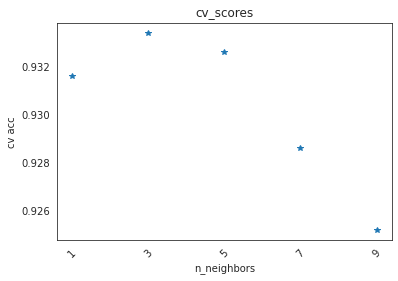

In [59]:
plt.title("cv_scores")
plt.xlabel('n_neighbors')
plt.ylabel('cv acc')
k_p = [1,3,5,7,9]

plt.xticks(range(len(k_p)), k_p, rotation=45)
_ = plt.plot(KNN_search['mean_test_score'].head(5), '*')
plt.show()

### Test Accuracy and Confusion Matrix

Precision and recall can also be defined for multiclass problems but we will skip them.


In [60]:
# evaluate the model and update the accuracies list
score = model.score(valData, valLabels)

accuracy= 93.98%
KNeighborsClassifier(n_neighbors=3)
----------------

Confusion matrix, without normalization
[[483   1   0   0   0   0   6   0   0   0]
 [  0 565   1   1   0   0   0   0   0   0]
 [  8  10 477   0   0   0   1  15   5   0]
 [  0   2   5 481   0  10   0   4   0   3]
 [  2   8   0   0 455   0   1   2   0  23]
 [  2   7   1  14   1 407   3   2   3   6]
 [  7   4   0   1   3   3 461   0   0   0]
 [  1  11   4   0   5   0   0 484   0   9]
 [  7   3   8  16   5  11   2   5 426   4]
 [  3   6   1   5  14   0   0  15   1 460]]


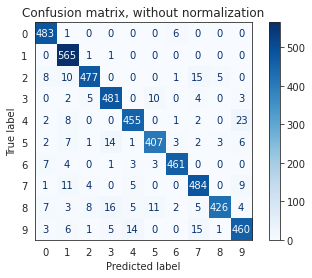

In [63]:
from sklearn.metrics import plot_confusion_matrix
np.set_printoptions(precision=2)

# Accuracy
print("accuracy= %.2f%%" % (score * 100))
print(model.best_estimator_)
print("----------------\n")
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None)]
class_names = [0,1,2,3,4,5,6,7,8,9]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, valData, valLabels, display_labels=class_names, cmap=plt.cm.Blues, normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
plt.show()

In [705]:
import pandas as pd
# Perform prediction
Prediction_KNN = model.predict_proba(valData)

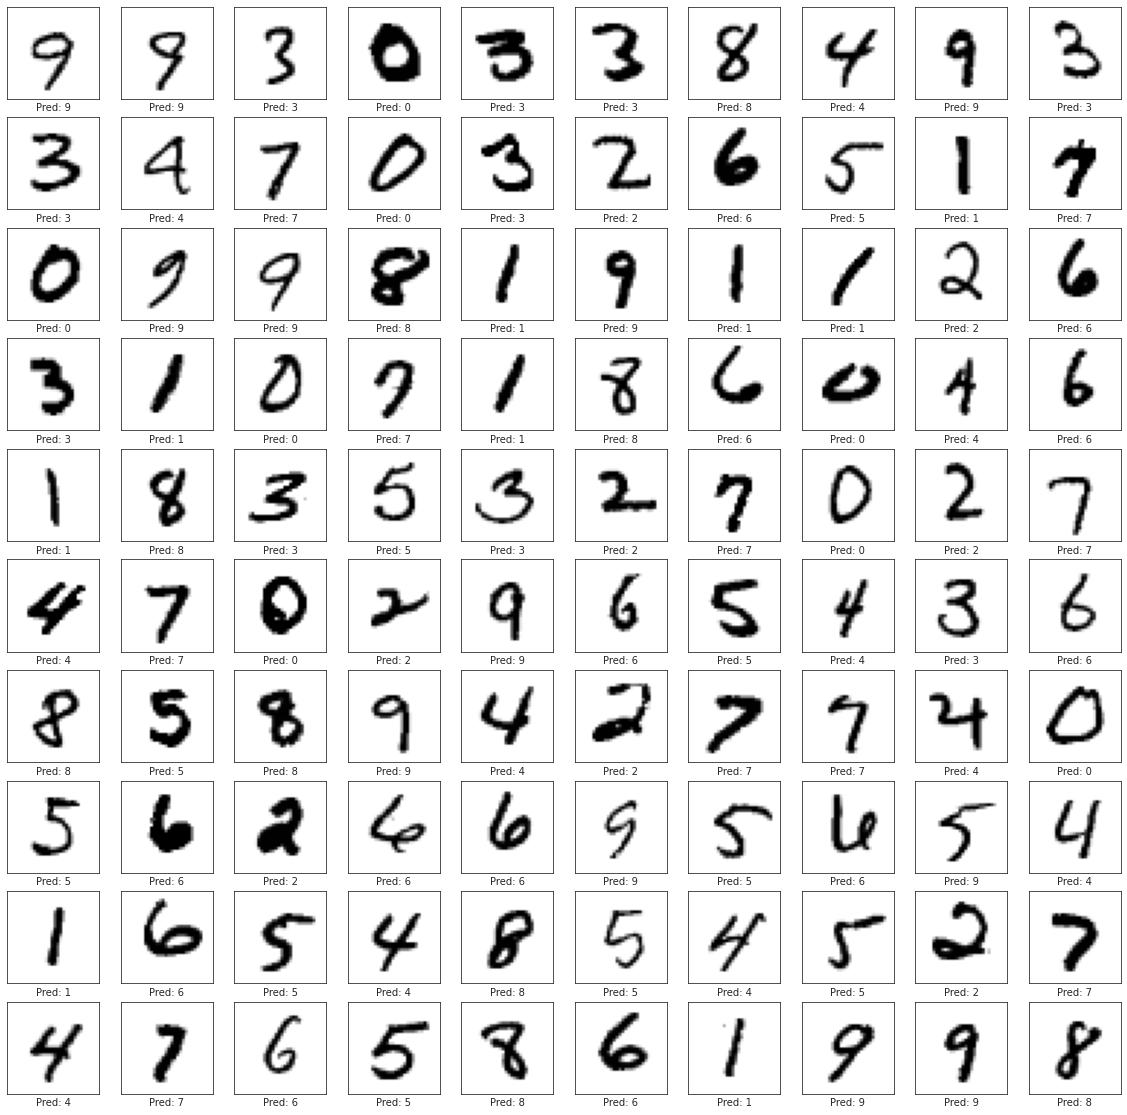

In [706]:
plt.figure(figsize=(20,20))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # Plot testing data
    plt.imshow(valData.iloc[i].values.reshape(32,32), cmap = plt.cm.binary)
    # Plot predicted label
    plt.xlabel("Pred: {0}".format((np.argmax(Prediction_KNN[i])))) 
plt.show()

### Conclusions on the $k$-NN classifier

Discuss your results here

 **°**  From the Grid search results we have considered 5 different numbers, from which we have extracted the mean test score for each case and have ordered in desceding order, weighted by its score values. From the graph above, we can see that when we have 3 neighbors we obtain the best accuracy. This means that for the KNN, we require 3 neighboring pixels to obtain the best pixel prediction, in this case, to represent a pixel that fits with the corresponding number structure, either 0 or 255. 
 
**°**  From the confusion_matrix we can deduce the following statements:
     - # 1 is the best predicted true label. 
     - # 5 is the worest predicted true label. 
     
**°**  It can also be seen that there are slight biases over pixel values, for example, on the number 2 we have that there are 477 true positive labels, but there are also 39 missmatches. 
Continuing with these observations, the number 1, the best predicted true label, also has some mismatches were it was confused as false positive, which explaines why the prediction is not perfect. On the other hand we have the worst predicted true label, the number 5, on which there were 39 mismatches with other labels and therefore the lefting predictions were totally missed, meaning that there were as well False Negatives during the prediction task. 

**°** From here we can see that the number 5 is confused with the number 9 in one ocasion. 

## MLP Classifier

### CV Hyperparametrization

Define an appropriate `MLPClassifier` and perform CV to select proper `alpha` and `hidden_layer_sizes` hyperparameters.

In [64]:
import os
import sys
import time
import pickle
import gzip

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import seaborn as sns

from sklearn.datasets import load_digits

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, GridSearchCV

from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

np.set_printoptions(precision=3)
import warnings
warnings.filterwarnings('ignore')

In [65]:
#define an appropriate MLP classifier and perform CV to select proper alpha and hidden_layer_sizes
n_folds = 10
skf = StratifiedKFold(n_folds, shuffle=True)

mlp_classifier = Pipeline(steps=[('std_sc', StandardScaler()),
                                 ('mlpc', MLPClassifier(solver='adam', 
                                  activation='relu',tol=1.e-4, max_iter=1000,
                                  warm_start=False, shuffle=True))])

l_hidden_layer_sizes = [(20,), (20, 20)]
l_alpha = [10.**k for k in range(-6, 4)]

param_grid = {'mlpc__alpha': l_alpha, 'mlpc__hidden_layer_sizes': l_hidden_layer_sizes}

mlpc_gscv = GridSearchCV(mlp_classifier, param_grid=param_grid, cv=skf, scoring='accuracy',
                         return_train_score=True, n_jobs=-1, verbose=1)

t_0 = time.time() 
print(trainData.shape)
_ = mlpc_gscv.fit(trainData,trainLabels)
t_1 = time.time() 
print("\nmlp_grid_search_time: {0:.2}f".format((t_1 - t_0)/60.))

# saving alpha_search in a pickle    
#joblib.dump(mlpc_gscv, 'mlp_classifier_gscv.joblib')

(5000, 1024)
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  9.2min finished



mlp_grid_search_time: 9.6f


### Search Results 

We first examine the test scores of the 5 best hyperparameters.

In [66]:
#transfor the CV results into a DataFrame and display the 5 best results
df_cv_estimator = pd.DataFrame.from_dict(mlpc_gscv.cv_results_)

display(df_cv_estimator[["param_mlpc__alpha", "param_mlpc__hidden_layer_sizes", "mean_test_score"]].sort_values(by="mean_test_score", ascending=False).head(5))

param_mlpc__alpha param_mlpc__hidden_layer_sizes  mean_test_score
13               1.0                       (20, 20)           0.9354
12               1.0                          (20,)           0.9304
10               0.1                          (20,)           0.9240
6              0.001                          (20,)           0.9222
9               0.01                       (20, 20)           0.9212

We analyze the CV results to check whether the CV ranges used are correct.

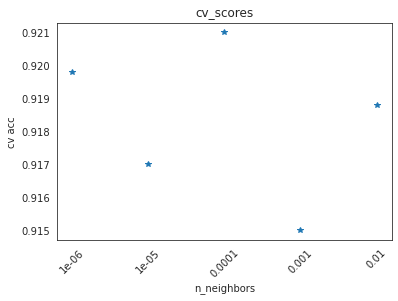

In [68]:
#plot the test scores that correspond to each alpha; do this only for the best MLP architecture found
plt.title("cv_scores")
plt.xlabel('alpha')
plt.ylabel('cv acc')
plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
_ = plt.plot(df_cv_estimator['mean_test_score'].head(5), '*')
plt.show()

best alpha: 1.000000	
alpha_min: 0.000001	alpha_max: 1000.000000
best_hidden_layer_sizes (20, 20) 
acc: 0.935


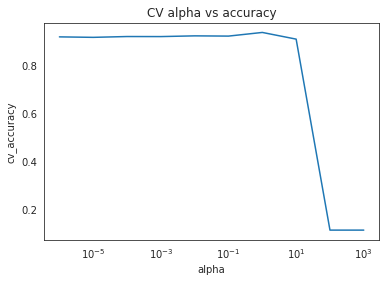

In [71]:
best_alpha = mlpc_gscv.best_params_['mlpc__alpha'] 
print("best alpha: %.6f\t" % best_alpha)
print("alpha_min: %f\talpha_max: %f" % (np.array(l_alpha).min(), np.array(l_alpha).max()))

best_hidden_layer_sizes = mlpc_gscv.best_params_['mlpc__hidden_layer_sizes'] 
print("best_hidden_layer_sizes", best_hidden_layer_sizes, "\nacc: %.3f" % mlpc_gscv.best_score_) 

idx_best_hidden_layer_sizes = [tup == best_hidden_layer_sizes for tup in df_cv_estimator['param_mlpc__hidden_layer_sizes'].values]
idx_best_hidden_layer_sizes = np.array(idx_best_hidden_layer_sizes)

plt.title("CV alpha vs accuracy")
plt.xscale('log')
plt.xlabel("alpha")
plt.ylabel("cv_accuracy")
_ = plt.plot( df_cv_estimator[idx_best_hidden_layer_sizes]['param_mlpc__alpha'], 
              df_cv_estimator[idx_best_hidden_layer_sizes]['mean_test_score'])

### Test MLPC Performance
We check the test accuracy and confusion matrix.

Accuarcy=  0.936
------------------------
Confusion matrix, without normalization
[[478   0   2   0   1   2   6   0   1   0]
 [  0 559   2   1   1   0   1   1   2   0]
 [  2   1 484   2   1   1   4  10  11   0]
 [  0   0   7 463   0  21   0   5   6   3]
 [  0   1   7   0 462   0   6   1   1  13]
 [  7   4   0  15   5 395   4   1   8   7]
 [  5   3  10   0   0  13 446   0   2   0]
 [  2   2  10   1   8   1   0 481   0   9]
 [  1   2   4   9   6   3   4   6 450   2]
 [  4   3   2   4  15   1   0  10   4 462]]


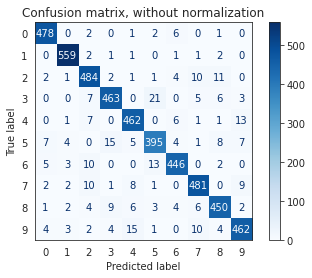

In [70]:
#compute the test predictions, their accuracy and confusion matrix and discuss your results
### CV accuracy, recall and precision of best model
y_pred = cross_val_predict(mlpc_gscv.best_estimator_, valData, valLabels, cv=skf, n_jobs=2)
 
score = mlpc_gscv.score(valData, valLabels)
print("Accuarcy= ", score)
print("------------------------")

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None)]
class_names = [0,1,2,3,4,5,6,7,8,9]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(mlpc_gscv, valData, valLabels, display_labels=class_names, cmap=plt.cm.Blues, normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

plt.show()

### Conclusions on the MLP classifier

Discuss your results here

Regarding the confusion matrix:


**°** The true label 1 has 559 true positives on MLP model, while on the KNN there were 565 true positives. 

**°** The worst predcted true label is still the number 5. However and in constrast with the KNN model, we can see that the that in this case we have 395 true labels, while in KNN we had 407. Meaning that in this case there were more mismatches for the labe 5. 


**°** This means that this calssificer is slightly worst than the KNN classifier by analyzing the minimum and maximun values. This explains why the accuracy is lower: 93.6 % in constrast with  93.98 for the first model

### Predicting probabilities

We compute class probabilities over the test subset and pairplot them over the 10 classes.

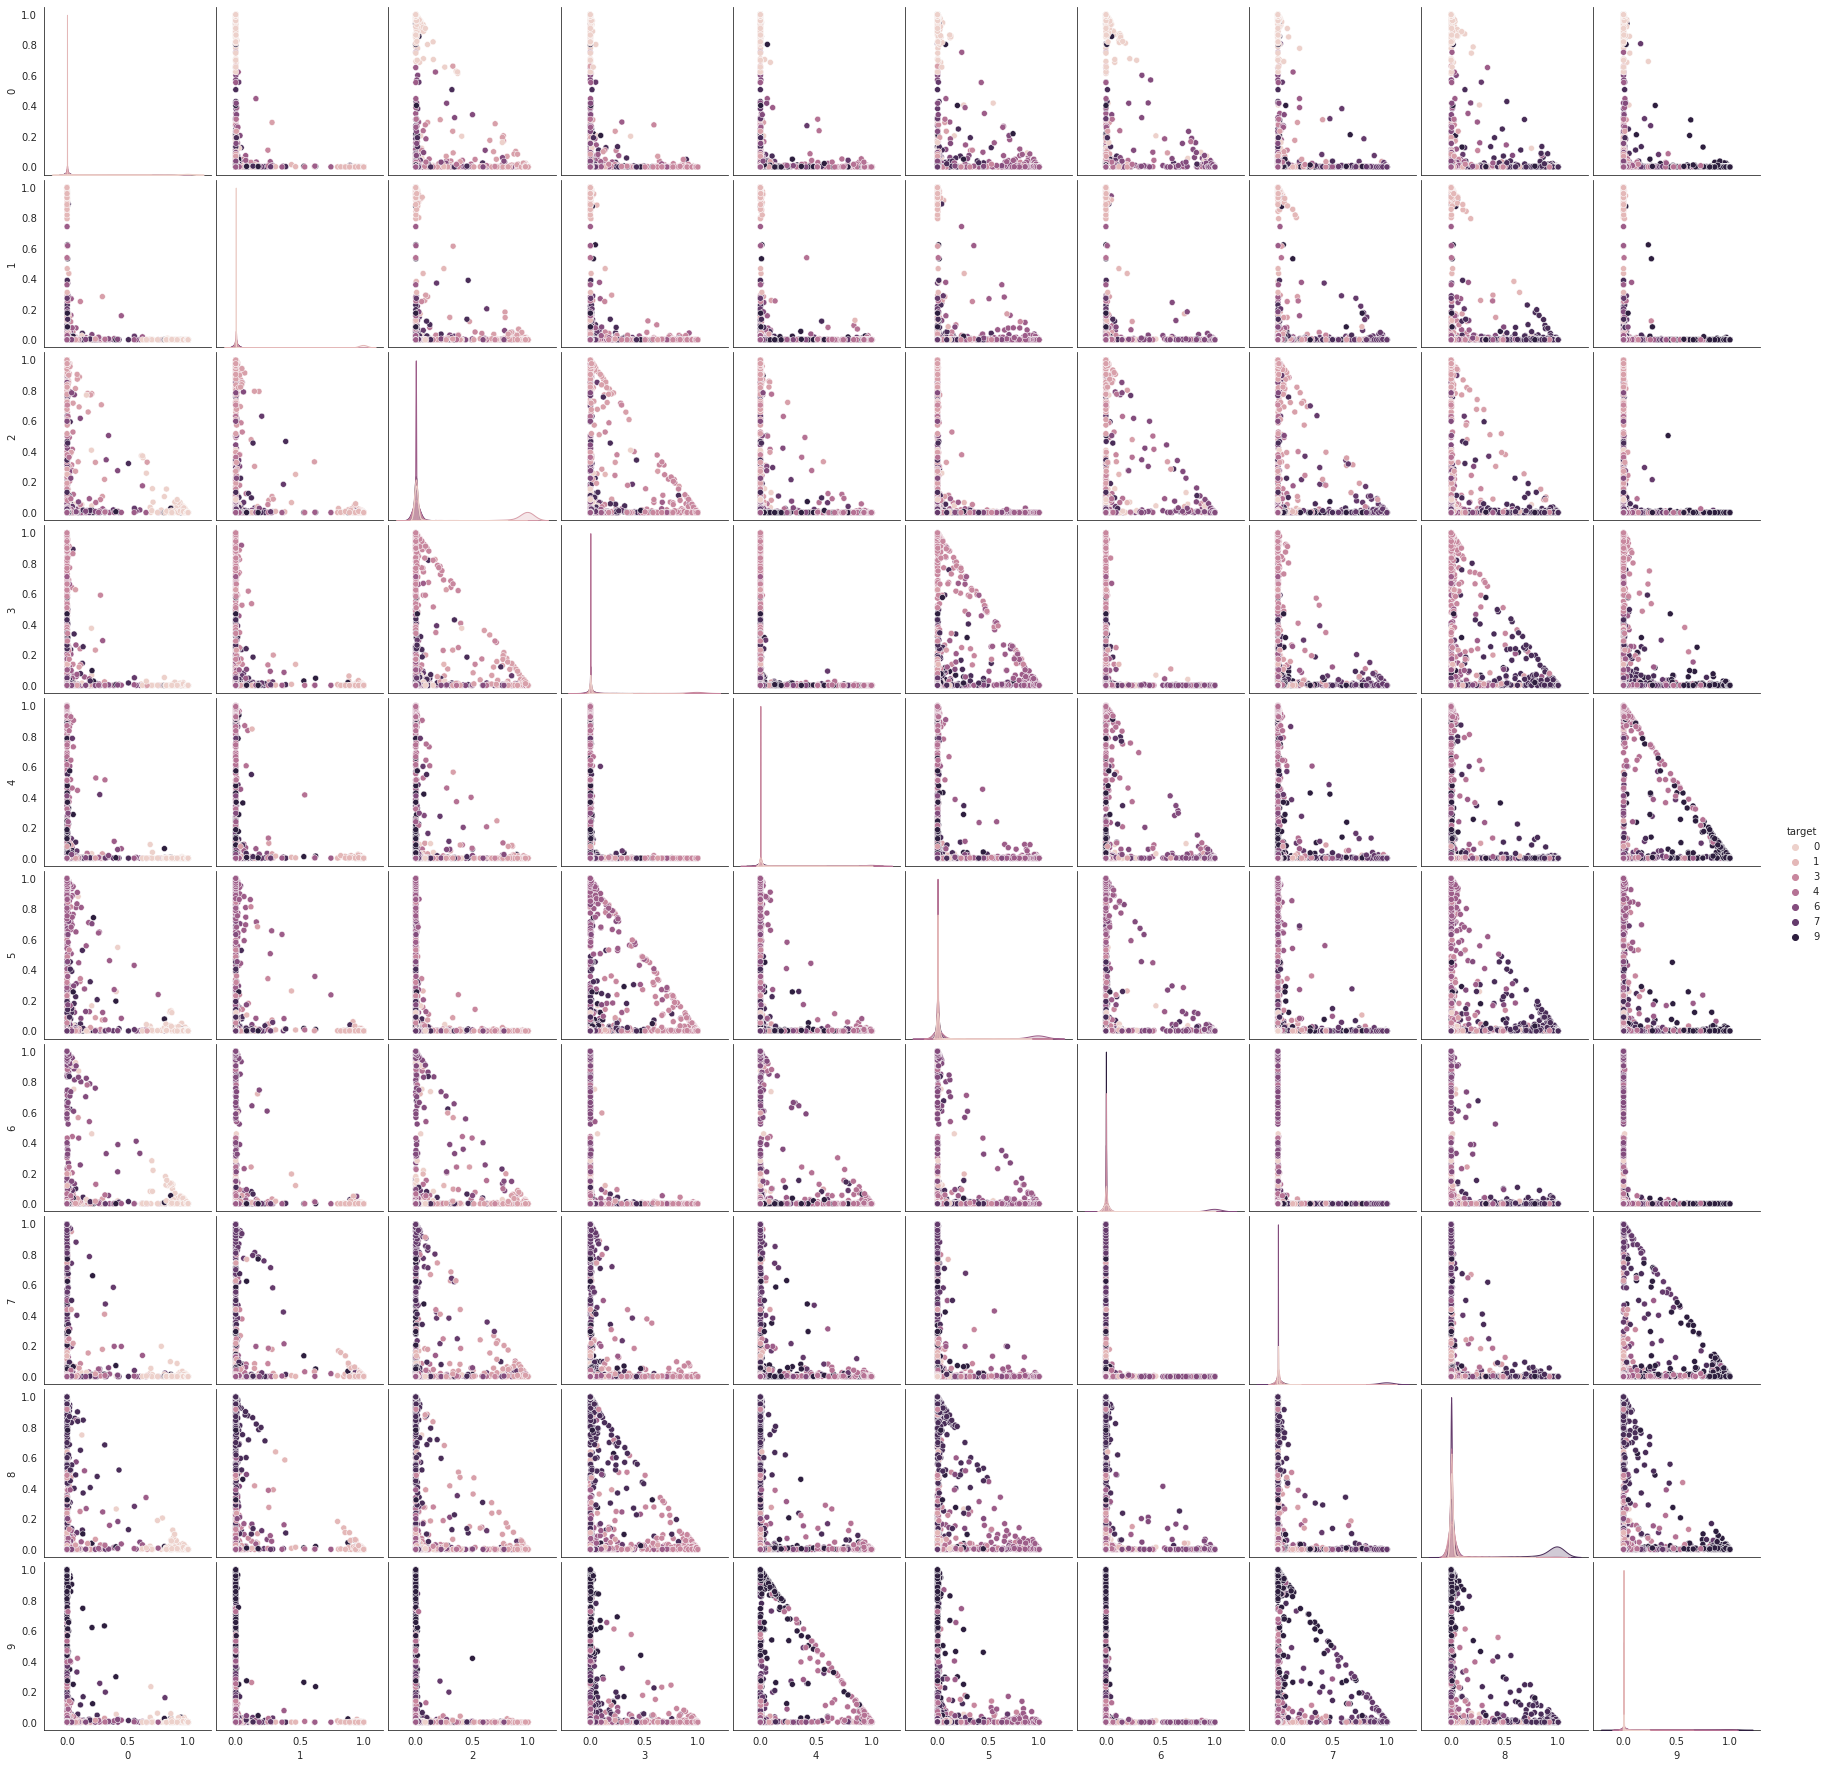

In [680]:
import pandas as pd
# Perform prediction
current_score = mlpc_gscv.predict_proba(valData)
# Convert to Dataframe
valLabels = pd.DataFrame(valLabels)
current_score = pd.DataFrame(current_score)
# Add column 'target' to index.
valLabels = valLabels.rename(columns={0:'target'})
pixel_range = pd.merge(current_score, valLabels, left_index=True, right_index=True)
# Plot pair-plot using hue : 'target' 
pair_plot = sns.pairplot(pixel_range, hue= 'target', diag_kind="kde", diag_kws=dict(shade=True))
plt.show()

In [714]:
current_score = current_score.round(1)
current_score.head(5)

0    1    2    3    4    5    6    7    8    9
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
2  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
3  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.5  0.0  0.5  0.0  0.0  0.0  0.0

### Conclusions on the probability pairplots

**°** From the diagonal we can see the the target values in comparaison with the predicted class probability represented as a number between 0 and 1. From the class 0 until the class number 9. From the class 0, we can see that the accuracy is very high, almost reaching 100%, so the pairplot allow us to visualize the data points or samples for each row of the 5000 datapoints of our classifier, and the datapoints to the right, sidewise on the right side of each plot of the diagonal, reprensent the incorrenctly classified datapoints. 

**°** The worst predicted class can be visualized on the labels 5 and 8, because if we inspect the diagonal plot, we can see on the righ side small datapoints that don't belong to the target class. 

**°** As annotation, we can see that all the [i,j] positions where i != j, that is, pairplots different from the diagonal, show a data points position distribution between the different classes. This means that the triangle shape is the result of 5000 datapoints over 10 classes probabilities and its clustering represents the dense probability ranges.

**°** When these clusters tend to approach to high probability values, then we can state that the label was correctly classified. Otherwise, the classifier should set their probability values near to zero and therefore the triangle shape should not be present, since this represents the missmatches and therefore higher error. We know each row should contain a single probability with value near to 1 or 100, since each number has a unique class.  

### What went wrong?

Probably your classification results are not very impressive.

As a first step to interpret them, find 10 cases of wrongly classified numbers, plot them and discuss your findings.  

Predicted pixel: 9


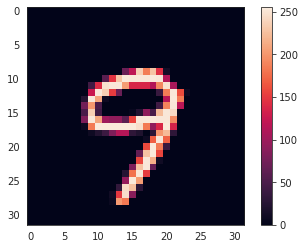

In [717]:
i=0
print("Predicted pixel: {0}".format(np.argmax(current_score.values[i])))
plt.figure()
plt.imshow(valData.iloc[i].values.reshape(32,32))
plt.colorbar()
plt.grid(False)
plt.show()

In [719]:
# Create column containing predictions as integers: 
predicted_Val = pd.DataFrame(np.zeros(shape=(5000,1)))
i = 0
for index,row in predicted_Val.iterrows():
    
    predicted_Val.loc[i] = np.argmax(current_score.values[i])
    i = i+1
predicted_Val = round(predicted_Val,1).astype('uint8')
valLabels = pd.DataFrame(valLabels)

In [721]:
df = valLabels.copy() 
df[1] = predicted_Val
df = df.rename(columns={0:'target', 1:'prediction'})
error_mpl = df[df['target']!=df['prediction']]
print(error_mpl.count())
error_mpl.head(10)

target        318
prediction    318
dtype: int64


target  prediction
109       5           1
113       8           4
132       9           7
133       2           7
136       9           3
170       8           0
189       4           9
195       0           4
209       8           3
214       8           2

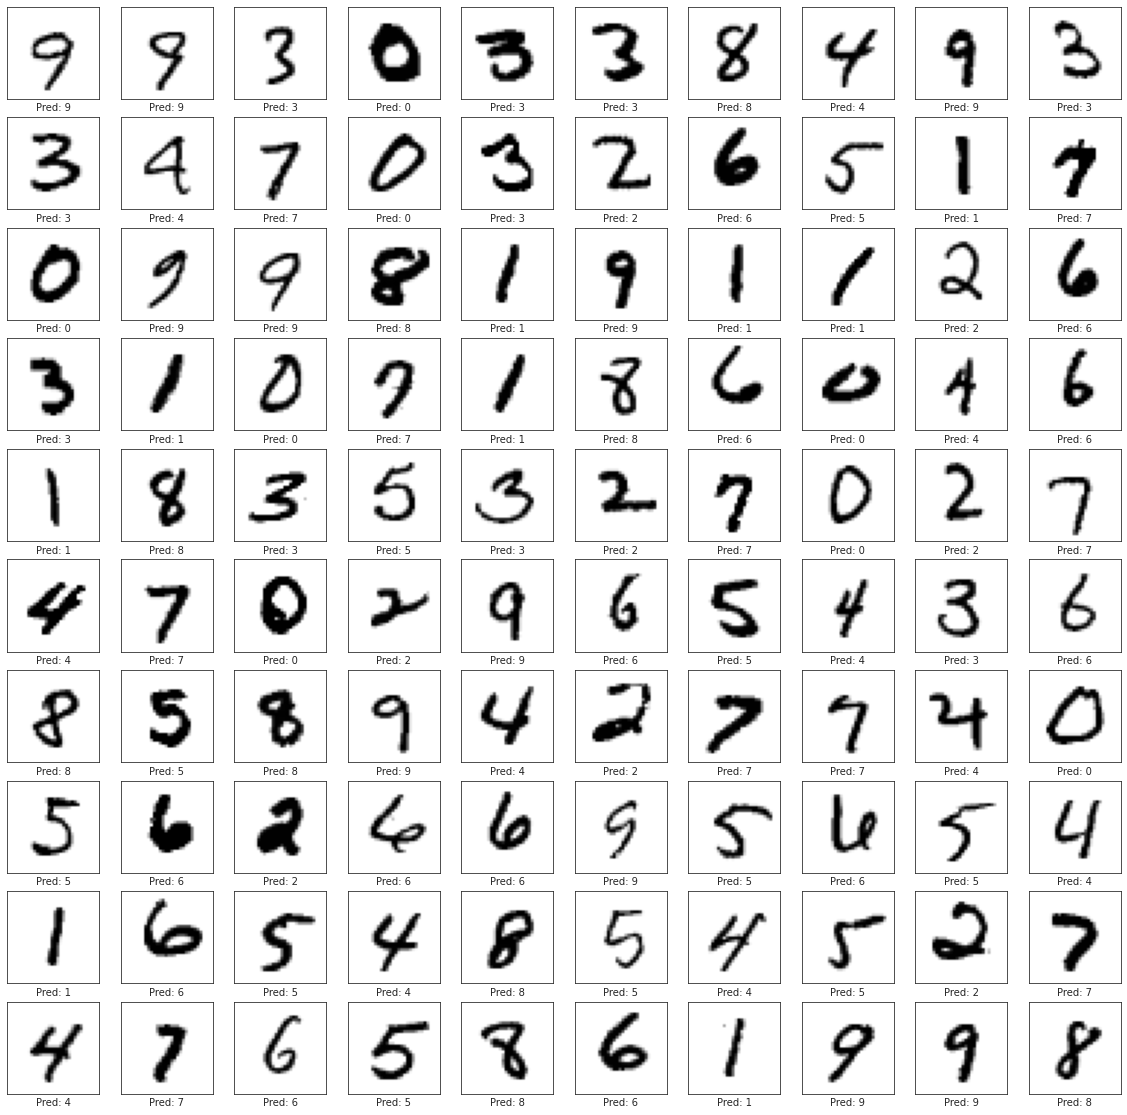

In [723]:
plt.figure(figsize=(20,20))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # Plot testing data
    plt.imshow(valData.iloc[i].values.reshape(32,32), cmap = plt.cm.binary)
    # Plot predicted label
    plt.xlabel("Pred: {0}".format(np.argmax(current_score.values[i]).round())) 
plt.show()

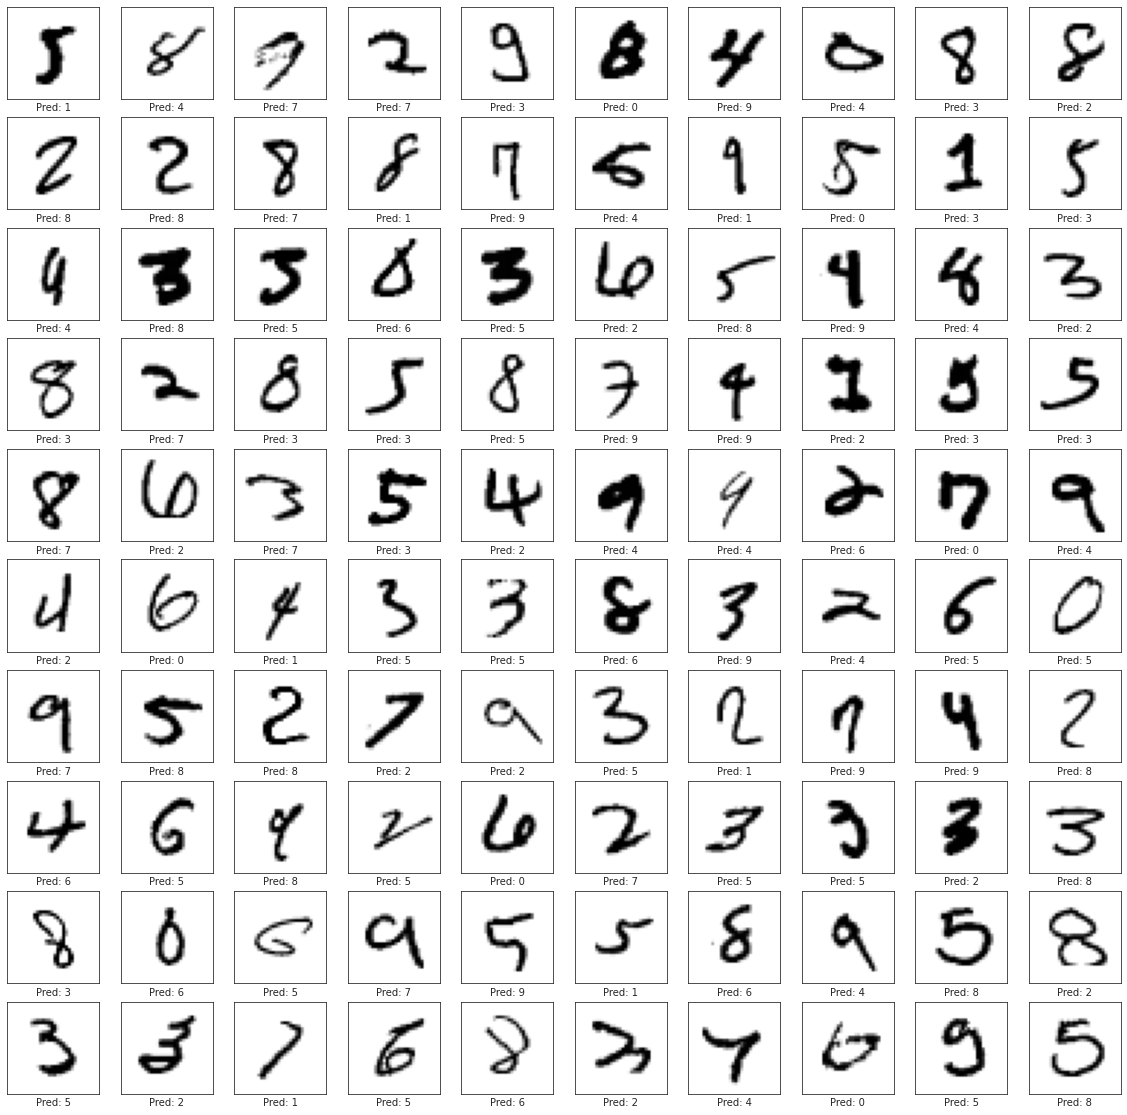

In [726]:
plt.figure(figsize=(20,20))
for i in range(100):
    j = error_mpl.index[i]
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # Plot testing data
    plt.imshow(valData.iloc[j].values.reshape(32,32), cmap = plt.cm.binary)
    # Plot predicted label
    plt.xlabel("Pred: {0}".format(np.argmax(current_score.values[j]).round())) 
plt.show()

### Remarks:
**°** From the above chart, we are able to evidence exactly where the classifier is making mistakes. In general, it is very effective for the classification of numbers on the range 0-9, but missclassifies the label 0 and sometimes fails when the numbers are too tilted, or extremly wrong written or in cases where its curves resamble the ones of other numbers. Similarly happened with the KNN classifier, which also showed a maximum classifications of labels '1', because it is the easiest one to predict, due to the easy-to follow topology of this array of pixels. 

## How to improve your results?

Recapitulate and discuss your results here and propose some ideas on how to improve them

**°** One possible way to improve our results can be, for the KNN model, to test with other possible K number of neighbors and re evaluate more candidates for the number of leafs, using alongside the Minkowski distance formula (p) parameters and storing themin a dictionary, we can keep testing posibilities with the GridSearchCV function, which optimizes by cross-validated grid-search over KNN model trained with the preprocessed dataset alongside with 10-fold cross validation. This showed that the best parameters were an euclidean distance (p) equal to 1, leafs = 1 and 3 neighbors, obtaining  afinal score of 93.98%.

**°** Regarding the MLP, using  a hidden number of layers of  20 each one, and an alpha parameter of 1.0, which helped to design a model with 93.54% score. A possible alternative to improve the model can be to implement different activation functions, such as 'tanh' and 'relu'. Different solver types, such as 'adam' or 'sdg'. And finally, testing with a wider learning rate range.